## Import

In [6]:
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import signal
plt.style.use('seaborn-colorblind')

## Présentation des données / Processing

In [7]:
data = pd.read_csv('test_acc.csv', engine = 'python')
#data = data.get(['x', 'y', 'z', 'delta de t'])
#data = pd.DataFrame.transpose(data)
print(data.shape)

(3192, 4)


In [8]:
data.head(12)

,x,y,z,delta de t
0,2.145,6.397,7.546,0
1,2.126,6.397,7.508,1
2,2.126,6.406,7.469,2
3,2.126,6.406,7.441,2
4,2.135,6.406,7.393,2
5,2.135,6.397,7.345,2
6,2.145,6.406,7.307,2
7,2.145,6.397,7.249,2
8,2.173,6.387,7.201,2
9,2.202,6.406,7.144,2


In [9]:
plt.figure();
pd.DataFrame.plot(data);
# Pourquoi ça plot pas ??

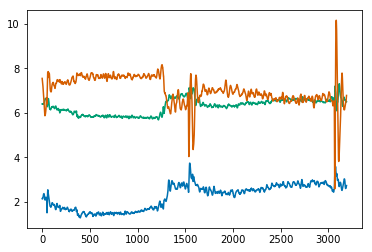

In [10]:
arrX = np.array(data.get(['x']))
arrY = np.array(data.get(['y']))
arrZ = np.array(data.get(['z']))
plt.figure()
plt.plot(arrX)
plt.plot(arrY)
plt.plot(arrZ)

In [12]:
filtre = [1, 1]
filteredX = signal.convolve(arrX, filtre)

ValueError: in1 and in2 should have the same dimensionality